In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_aa8d95c187254c98a58def3f8aa07c56 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_aa8d95c187254c98a58def3f8aa07c56 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_aa8d95c187254c98a58def3f8aa07c56 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='SW4aJ6E0SLqD85fz0UrkOv6TQXkAKx5j8h2aIqlOuwwN',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_aa8d95c187254c98a58def3f8aa07c56)

body = client_aa8d95c187254c98a58def3f8aa07c56.get_object(Bucket='predictingwindenergy-donotdelete-pr-vjzefpx0x2czvw',Key='T1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset = pd.read_csv(body)
dataset.head()


Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286

In [3]:
dataset.rename(columns={'Date/Time':'Time',
                   'LV ActivePower (kW)':'ActivePower(kW)',
                   "Wind Speed (m/s)":"WindSpeed(m/s)",
                   "Wind Direction (°)":"Wind_Direction"},
                    inplace=True)

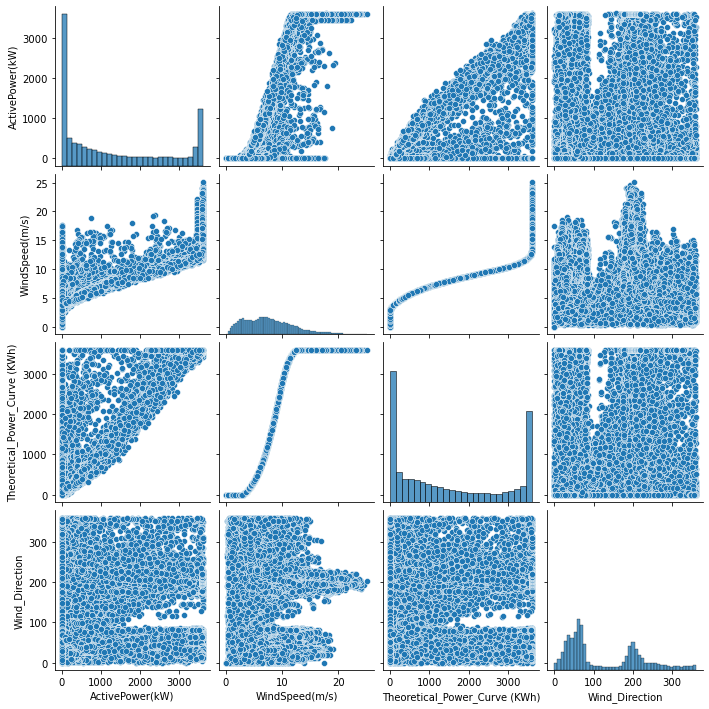

In [4]:
sns.pairplot(dataset)

In [5]:
corr = dataset.corr()
plt.figure(figsize=(10, 8))

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

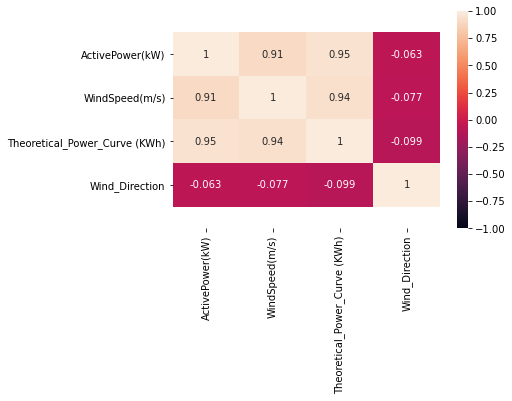

ActivePower(kW)  WindSpeed(m/s)  \
ActivePower(kW)                       1.000000        0.912774   
WindSpeed(m/s)                        0.912774        1.000000   
Theoretical_Power_Curve (KWh)         0.949918        0.944209   
Wind_Direction                       -0.062702       -0.077188   

                               Theoretical_Power_Curve (KWh)  Wind_Direction  
ActivePower(kW)                                     0.949918       -0.062702  
WindSpeed(m/s)                                      0.944209       -0.077188  
Theoretical_Power_Curve (KWh)                       1.000000       -0.099076  
Wind_Direction                                     -0.099076        1.000000

In [6]:
ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
corr

In [7]:
#df.drop(['Wind_Direction'],axis=1,inplace = True)
dataset["Time"] = pd.to_datetime(dataset["Time"], format = "%d %m %Y %H:%M", errors = "coerce")
dataset

Time  ActivePower(kW)  WindSpeed(m/s)  \
0     2018-01-01 00:00:00       380.047791        5.311336   
1     2018-01-01 00:10:00       453.769196        5.672167   
2     2018-01-01 00:20:00       306.376587        5.216037   
3     2018-01-01 00:30:00       419.645905        5.659674   
4     2018-01-01 00:40:00       380.650696        5.577941   
...                   ...              ...             ...   
50525 2018-12-31 23:10:00      2963.980957       11.404030   
50526 2018-12-31 23:20:00      1684.353027        7.332648   
50527 2018-12-31 23:30:00      2201.106934        8.435358   
50528 2018-12-31 23:40:00      2515.694092        9.421366   
50529 2018-12-31 23:50:00      2820.466064        9.979332   

       Theoretical_Power_Curve (KWh)  Wind_Direction  
0                         416.328908      259.994904  
1                         519.917511      268.641113  
2                         390.900016      272.564789  
3                         516.127569      271.258087  
4                         491.702972      265.674286  
...                              ...             ...  
50525                    3397.190793       80.502724  
50526                    1173.055771       84.062599  
50527                    1788.284755       84.742500  
50528                    2418.382503       84.297913  
50529                    2779.184096       82.274620  

[50530 rows x 5 columns]

In [8]:
y = dataset['ActivePower(kW)'] #'Theoretical_Power_Curve (KWh)'
X = dataset[['Theoretical_Power_Curve (KWh)','WindSpeed(m/s)']]#'ActivePower(kW)'


In [9]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

In [11]:
forest_model = RandomForestRegressor(max_leaf_nodes =500, random_state=1)
forest_model.fit(train_X, train_y)

RandomForestRegressor(max_leaf_nodes=500, random_state=1)

In [12]:
power_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, power_preds))
print(r2_score(val_y,power_preds))
joblib.dump(forest_model, "power_prediction.sav")

162.90876721041636
0.9015207981707474


['power_prediction.sav']

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import joblib

In [14]:
loaded_model = joblib.load('power_prediction.sav')

In [15]:
#X = [['Theoretical_Power_Curve (KWh)','WindSpeed(m/s)']]
print(loaded_model.predict([[416.328907824861,5.31133604049682]])[0],"KWh")

348.19165981990403 KWh


In [16]:
!pip install ibm_watson_machine_learning


In [17]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey":"8r_73r_kobxkRh4xVZMTU29nikPAwCq3_2et93LJDKCj"
                  }
client = APIClient(wml_credentials)


In [18]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    #print(space)
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])


In [19]:
space_uid = guid_from_space_name(client, 'energy')
print(space_uid)

1e5e911c-4043-4db0-a455-0bb24e388bc9


In [20]:
client.set.default_space(space_uid)

'SUCCESS'

In [21]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029

In [22]:
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.8")
software_spec_uid

'ab9e1b80-f2ce-592c-a7d2-4f2344f77194'

In [23]:
 model_details = client.repository.store_model(model=forest_model,meta_props={
 client.repository.ModelMetaNames.NAME:"wind_modeling",
 client.repository.ModelMetaNames.TYPE:"scikit-learn_0.23",
 client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid }
                                             )
model_id = client.repository.get_model_uid(model_details)

In [24]:
model_id

'4248b8a5-7448-4789-9918-a16a5a05b970'